In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import sklearn.metrics as metrics
import timm
from torchvision import transforms

/Users/masha/Documents/visual-reasoning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {DEVICE}")

CHIRAL_SHAPES = {
    'L': [(0, -1), (0, 0), (0, 1), (1, 1)],
    'J': [(0, -1), (0, 0), (0, 1), (-1, 1)],
    'S': [(0, 0), (1, 0), (0, 1), (-1, 1)],
    'Z': [(0, 0), (-1, 0), (0, 1), (1, 1)],
}

def draw_shape(name, size):
    img = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    block_size = size // 8 
    for dx, dy in CHIRAL_SHAPES[name]:
        x = center + (dx * block_size) - (block_size // 2)
        y = center + (dy * block_size) - (block_size // 2)
        cv2.rectangle(img, (x, y), (x + block_size, y + block_size), 255, -1)
    return img

class ReasoningDataset(Dataset):
    def __init__(self, n_samples=200):
        self.data = []
        keys = list(CHIRAL_SHAPES.keys())
        for _ in range(n_samples):
            key = random.choice(keys)
            
            # Image A
            img_a_np = draw_shape(key, 64)
            
            # Image B (Target)
            is_same = (random.random() > 0.5)
            angle_diff = random.randint(0, 360)
            
            # Rotate
            center = (32, 32)
            M = cv2.getRotationMatrix2D(center, angle_diff, 1.0)
            img_b_np = cv2.warpAffine(img_a_np, M, (64, 64))
            
            # Mirror if "Different"
            if not is_same:
                img_b_np = cv2.flip(img_b_np, 1) 
            
            # Normalize -1..1
            def norm(x): return (torch.tensor(x).float().unsqueeze(0)/255.0 - 0.5)/0.5
            
            self.data.append((norm(img_a_np), norm(img_b_np), 1.0 if is_same else 0.0))

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

dino = timm.create_model("vit_small_patch16_dinov3", pretrained=True).to(DEVICE).eval()

def get_dino_embedding(img_64_tensor):
    # Resize 64 -> 224
    img = (img_64_tensor * 0.5) + 0.5 # 0..1
    img = F.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)
    img = img.repeat(1, 3, 1, 1) # 1ch -> 3ch
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = norm(img)
    
    with torch.no_grad():
        emb = dino.forward_features(img)[:, 0, :]
    return emb

print("Running DINO Similarity Check...")
test_loader = DataLoader(ReasoningDataset(200), batch_size=1)

y_true = []
y_scores = []

for i, (img_a, img_b, label) in enumerate(test_loader):
    img_a = img_a.to(DEVICE)
    img_b = img_b.to(DEVICE)
    
    # Get Embeddings
    emb_a = get_dino_embedding(img_a)
    emb_b = get_dino_embedding(img_b)
    
    # Calculate Cosine Similarity
    sim = F.cosine_similarity(emb_a, emb_b).item()
    
    y_true.append(label.item())
    y_scores.append(sim)

Running on mps
Running DINO Similarity Check...



DINO Baseline AUC: 0.4867


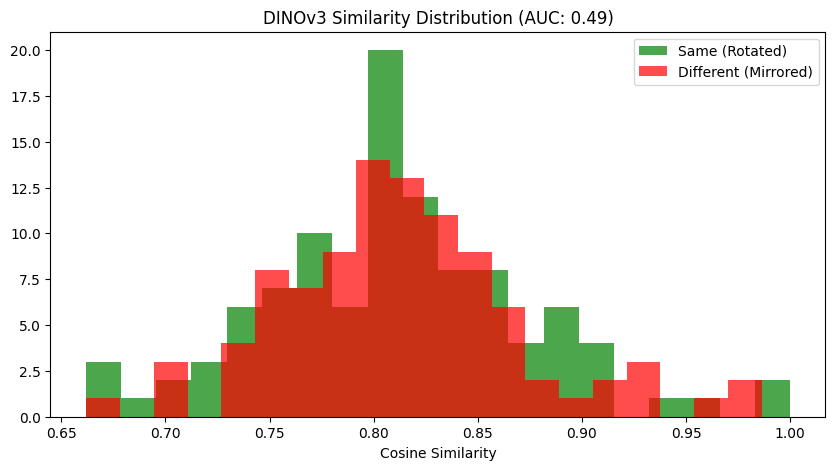

In [4]:
auc = metrics.roc_auc_score(y_true, y_scores)
print(f"\nDINO Baseline AUC: {auc:.4f}")

plt.figure(figsize=(10, 5))
plt.hist([s for s, t in zip(y_scores, y_true) if t == 1.0], bins=20, alpha=0.7, color='green', label='Same (Rotated)')
plt.hist([s for s, t in zip(y_scores, y_true) if t == 0.0], bins=20, alpha=0.7, color='red', label='Different (Mirrored)')
plt.title(f"DINOv3 Similarity Distribution (AUC: {auc:.2f})")
plt.xlabel("Cosine Similarity")
plt.legend()
plt.show()

Running DINO L1 Distance Evaluation...

DINO L1 Baseline AUC: 0.4905


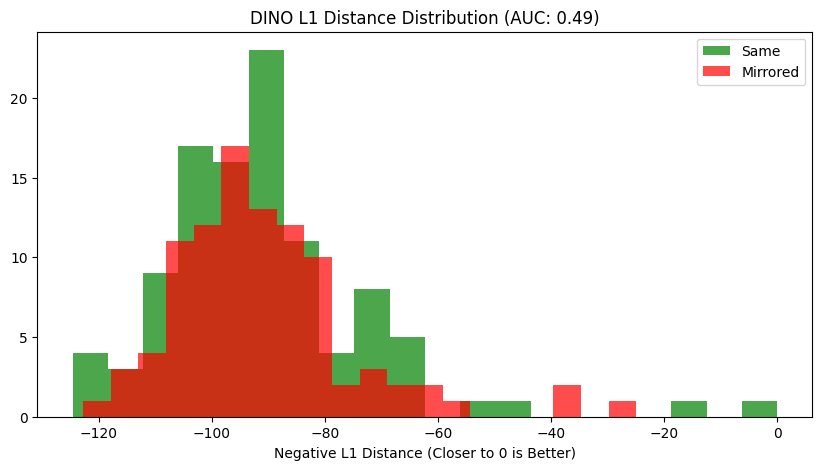

In [ ]:
print("Running DINO L1 Distance Evaluation...")

y_true = []
y_scores = [] # We will use Negative Distance (Higher = Closer = Better)

for i, (img_a, img_b, label) in enumerate(test_loader):
    img_a = img_a.to(DEVICE)
    img_b = img_b.to(DEVICE)
    
    # Get Embeddings
    emb_a = get_dino_embedding(img_a)
    emb_b = get_dino_embedding(img_b)
    
    # Calculate L1 Distance (Manhattan)
    # Sum of absolute differences
    l1_dist = torch.sum(torch.abs(emb_a - emb_b)).item()
    
    y_true.append(label.item())
    # AUC requires "Higher Score = Positive Class". 
    # Since Distance is "Lower is Better", we use Negative Distance.
    y_scores.append(-l1_dist)

auc = metrics.roc_auc_score(y_true, y_scores)
print(f"\nDINO L1 Baseline AUC: {auc:.4f}")

plt.figure(figsize=(10, 5))
plt.hist([s for s, t in zip(y_scores, y_true) if t == 1.0], bins=20, alpha=0.7, color='green', label='Same')
plt.hist([s for s, t in zip(y_scores, y_true) if t == 0.0], bins=20, alpha=0.7, color='red', label='Mirrored')
plt.title(f"DINO L1 Distance Distribution (AUC: {auc:.2f})")
plt.xlabel("Negative L1 Distance (Closer to 0 is Better)")
plt.legend()
plt.show()

Running DINO L2 Distance Evaluation...

DINO L2 Baseline AUC: 0.4858


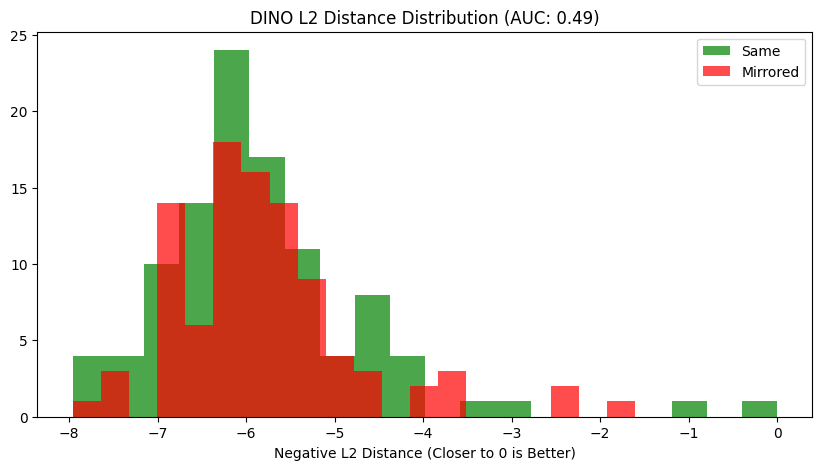

In [6]:
print("Running DINO L2 Distance Evaluation...")

y_true = []
y_scores = [] 

for i, (img_a, img_b, label) in enumerate(test_loader):
    img_a = img_a.to(DEVICE)
    img_b = img_b.to(DEVICE)
    
    # Get Embeddings
    emb_a = get_dino_embedding(img_a)
    emb_b = get_dino_embedding(img_b)
    
    # Calculate L2 Distance (Euclidean)
    l2_dist = torch.dist(emb_a, emb_b, p=2).item()
    
    y_true.append(label.item())
    y_scores.append(-l2_dist) # Negative because Lower Distance is Better

auc = metrics.roc_auc_score(y_true, y_scores)
print(f"\nDINO L2 Baseline AUC: {auc:.4f}")

plt.figure(figsize=(10, 5))
plt.hist([s for s, t in zip(y_scores, y_true) if t == 1.0], bins=20, alpha=0.7, color='green', label='Same')
plt.hist([s for s, t in zip(y_scores, y_true) if t == 0.0], bins=20, alpha=0.7, color='red', label='Mirrored')
plt.title(f"DINO L2 Distance Distribution (AUC: {auc:.2f})")
plt.xlabel("Negative L2 Distance (Closer to 0 is Better)")
plt.legend()
plt.show()